In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from IPython.display import display
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from collections import OrderedDict
from pypfopt.efficient_frontier import EfficientFrontier







In [2]:
# Load data
prices_df = pd.read_csv('data\Russell3000_prices_clean.csv')
prices_df['Date'] = pd.to_datetime(prices_df['Date'], dayfirst=True)
prices_df.sort_values(by='Date', inplace=True)

all_stocks = prices_df.columns[1:100]
training_stocks = all_stocks[1:75]
other_stocks = all_stocks[75:]

# Calculate returns
returns_df = prices_df[all_stocks].pct_change()
returns_df = returns_df.dropna().reset_index(drop=True)
returns_df.insert(0, 'Date', prices_df['Date'][:-1])

# Convert to numpy array (for easier calculations)
returns_matrix = returns_df.iloc[:, 1:].to_numpy()




In [3]:
forecast_horizon = 21 # trading days
test_start_date = pd.to_datetime('2015-01-01')
test_end_date = pd.to_datetime('2020-01-01')

messages = {"test_start": [], "test_end": []}

# Check if test_start_date exists in the DataFrame, if not, take the next date that exists
if test_start_date not in returns_df['Date'].values:
    test_start_date = returns_df['Date'][returns_df['Date'] > test_start_date].bfill().iloc[0]
    messages["test_start"] = messages["test_start"] or ['Start date not found, using closest next date instead.']

# Check if test_end_date exists in the DataFrame, if not, take the previous date that exists
if test_end_date not in returns_df['Date'].values:
    test_end_date = returns_df['Date'][returns_df['Date'] < test_end_date].ffill().iloc[-1]
    messages["test_end"] = messages["test_end"] or ['End date not found, using closest date instead.']

test_start = returns_df.loc[returns_df['Date'] == test_start_date].index[0]
test_end = returns_df.loc[returns_df['Date'] == test_end_date].index[0]

del test_start_date, test_end_date, messages

Helper methods

In [4]:
#functions
def get_portfolio_weights(volatility):
    inv_volatilities = np.array([1/volatility[stock] \
                                 if volatility[stock] > 0 else 0 for stock in all_stocks])
    total = np.sum(inv_volatilities)
    return inv_volatilities / total if total > 0 else np.zeros(len(all_stocks))



methods = defaultdict(lambda: defaultdict(list))
"""
def gather_portfolio_metrics(method, i, volatility):
    # Record predicted volatility for each stock

    for stock in all_stocks:
        methods[method][stock + " predicted volatility"].extend([volatility[stock]])
        
    # Calculate portfolio weights based on volatility
    weights = get_portfolio_weights(volatility)
    
    # Calculate portfolio returns for each day in the window
    returns = np.dot(returns_matrix[i:i+forecast_horizon], weights)
    
    # Record portfolio returns
    methods[method]["returns"].extend(returns)
    """

def gather_portfolio_metrics(method: str, i: int, weights: OrderedDict, volatility) -> None:
    # Calculate portfolio returns for each day in the window
    for stock in all_stocks:
        methods[method][stock + " predicted volatility"].extend([volatility[stock]])

    returns = np.dot(returns_matrix[i:i+forecast_horizon], np.array(list(weights.values())))
    methods[method]["returns"].extend(returns)
    methods[method]["std"].append(np.std(returns))
    
def reset_portfolio_metrics(method):
    for stock in all_stocks:
        methods[method][stock + " predicted volatility"] = []
    methods[method]["returns"] = []

def standardize_returns(returns_matrix):
    mean_returns = np.mean(returns_matrix)
    std_returns = np.std(returns_matrix)
    standardized_returns = np.where(std_returns!=0, (returns_matrix - mean_returns) / std_returns, 0)
    return standardized_returns.reshape(-1, 1)

def get_linear_regression_model(X, y, fit_intercept=True, positive=False):
    model = LinearRegression(fit_intercept=fit_intercept, positive=positive)
    model.fit(X, y)

    return model

def predict_corr(betas: list) -> np.ndarray:
    
    predicted_correlations = np.outer(betas, betas)
    psi_matrix = np.diag(1 - np.diag(predicted_correlations))
    return predicted_correlations + psi_matrix

Benchmark models(oracle, equal weight)

In [5]:
"""
method = "Oracle" + "+" + str(forecast_horizon)
reset_portfolio_metrics(method)

for i in range(test_start, test_end, forecast_horizon):
    # Trying to predict the volatility of the next forecast_horizon days
    volatility = {stock: returns_df[stock][i: i + forecast_horizon].std() \
                  for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

method = "EqualWeight"
reset_portfolio_metrics(method)

for i in range(test_start, test_end, forecast_horizon):
    # We assume equal volatility across all stocks, simplifying our model to equal weights.
    volatility = {stock: 1 for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)
"""


'\nmethod = "Oracle" + "+" + str(forecast_horizon)\nreset_portfolio_metrics(method)\n\nfor i in range(test_start, test_end, forecast_horizon):\n    # Trying to predict the volatility of the next forecast_horizon days\n    volatility = {stock: returns_df[stock][i: i + forecast_horizon].std()                   for stock in all_stocks}\n\n    gather_portfolio_metrics(method, i, volatility)\n\nmethod = "EqualWeight"\nreset_portfolio_metrics(method)\n\nfor i in range(test_start, test_end, forecast_horizon):\n    # We assume equal volatility across all stocks, simplifying our model to equal weights.\n    volatility = {stock: 1 for stock in all_stocks}\n\n    gather_portfolio_metrics(method, i, volatility)\n'

In [6]:
#covariation matrix for all stocks
volatility = {stock: returns_df[stock][test_start: test_end].std() for stock in all_stocks}

values = np.array(list(volatility.values()))

correlation_matrix = returns_df.iloc[:, 1:].corr()

covariation_matrix = correlation_matrix * np.outer(values, values)

del volatility

In [7]:
returns_temp = returns_df.copy()

returns_temp['Date'] = pd.to_datetime(returns_temp['Date'])
returns_temp.set_index('Date', inplace=True)

In [8]:
#get data for vix index
import yfinance as yf

vix = yf.Ticker("^VIX")

vix_data = vix.history(start="2000-01-01", end="2020-01-01")
vix_data.index = vix_data.index.tz_localize(None)



vix_data = vix_data[["Close"]]

vix_data = vix_data.reindex(returns_temp.index)
vix_data.ffill(inplace=True)




In [9]:
global window, train_start, train_end
window = 21 # Set window to 21 days from now on for computational efficiency
train_start = (test_start - window) % forecast_horizon + window + 126
train_end = test_start # Training end is the start of the test period

x_label = ['std 1w', 'std 1m', 'std 3m', 'std 6m', 'mean_ret 1w', 'mean_ret 1m', 'mean_ret 3m', 'mean_ret 6m', 'mean_vix 1w', 'mean_vix 1m', 'mean_vix 3m', 'mean_vix 6m','beta 1w', 'beta 1m', 'beta 3m', 'beta 6m'] 
windows = [5, 21, 63, 126]


market_index_returns = []

for i in range(0, test_end, forecast_horizon):
    # We assume equal volatility across all stocks, simplifying our model to equal weights.
    volatility = {stock: 1 for stock in all_stocks}

    #gather_portfolio_metrics(method, i, volatility)
    # Calculate portfolio weights based on volatility
    weights = get_portfolio_weights(volatility)

    # Calculate portfolio returns for each day in the window
    returns = np.dot(returns_matrix[i:i+forecast_horizon], weights)
    
    # Record portfolio returns
    market_index_returns.extend(returns)
    

Linear regression models

In [10]:
def get_linear_regression_model(A, B, fit_intercept=True):
    # Fit a linear regression model with non-negative coefficients and no intercept
    model = LinearRegression(positive=True, fit_intercept=fit_intercept)
    model.fit(np.array(A), np.array(B))

    return model

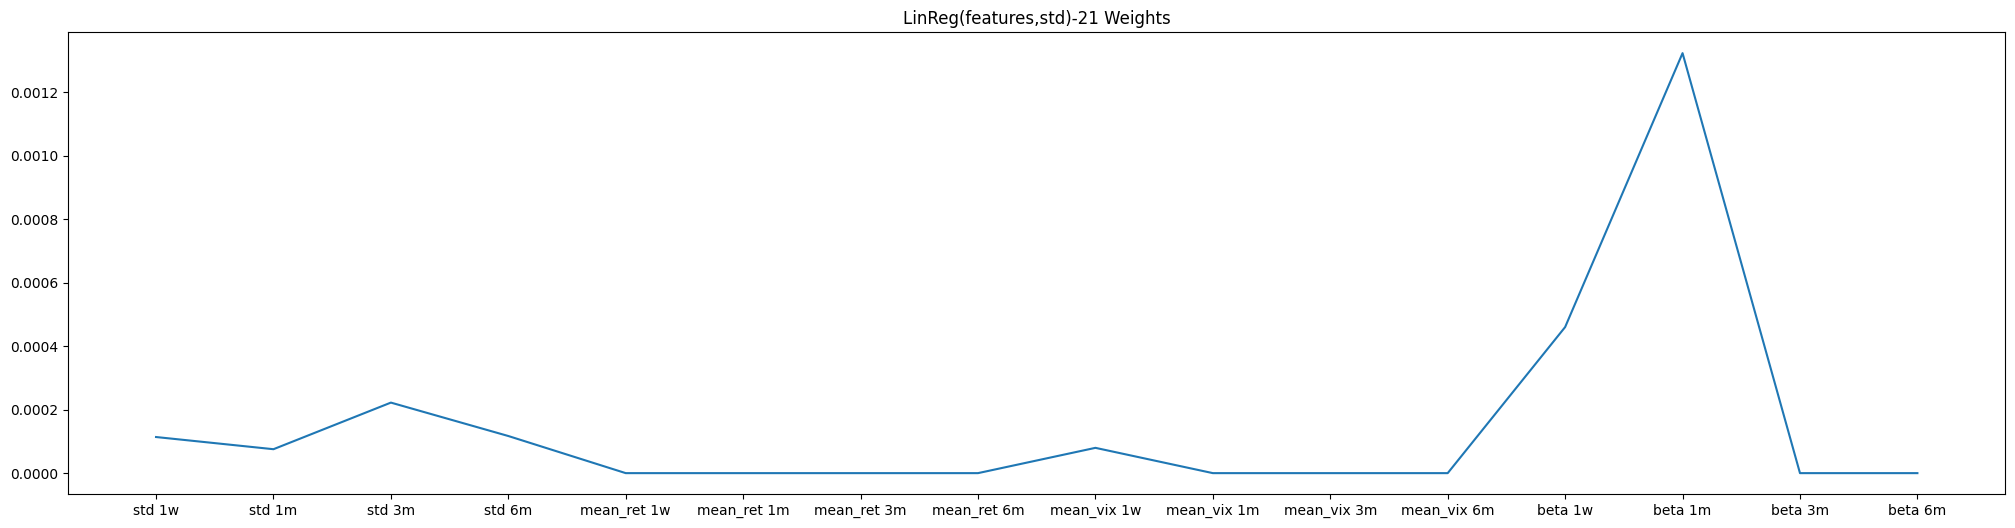

In [11]:
method = "LinReg(features,std)" + "-" + str(forecast_horizon)
#reset_portfolio_metrics(method)

A, B = [], []
# Iterate over each window of returns
for stock in training_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        std = []
        mean_ret = []
        mean_vix = []
        betas = []

        for window in windows:

            #dobij sve feature koje ubacujemo u model
            std.append(returns_df[stock][i - window:i].std()* (252 ** 0.5) * 100)
            mean_ret.append(returns_df[stock][i - window:i].mean() * 252)
            mean_vix.append(float(vix_data[i - window: i].mean().iloc[0]))

            standardized_returns = standardize_returns(returns_df[stock][i - window:i])
            standardized_market_index_returns = standardize_returns(market_index_returns[i - window:i])
        
            X = standardized_returns
            y = standardized_market_index_returns
           
            model = get_linear_regression_model(X, y, fit_intercept=False)
            beta = model.coef_[0][0]
            if abs(beta) >= 1:
                raise Exception(f"Beta value {beta} is not in the range [-1, 1]")
            betas.append(beta)

        # Grupiraj kvadrirane povrate i prosječni VIX u jednu listu prije dodavanja u A
        features = std + mean_ret + mean_vix + betas
        
        # Sada dodaj tu listu kao jedan element u A
        A.append(features)
        B.append(returns_df[stock][i:i + forecast_horizon].std())


methods[method]["model"] = get_linear_regression_model(A, B, False) 
# Intercept might make variance negative

plt.figure(figsize=(25, 6))
plt.plot(methods[method]["model"].coef_)
plt.title(method + " Weights")
plt.xticks(range(len(x_label)), x_label)
plt.show()

volatility = {}

for i in range(test_start, test_end, forecast_horizon):

    betas_for_corr = []
    temp = []
    
    for stock in all_stocks:

        std = []
        mean_ret = []
        mean_vix = []
        betas = []

        for window in windows:
            #dobij sve feature koje ubacujemo u model
            std.append(returns_df[stock][i - window:i].std() * (252 ** 0.5) * 100)
            mean_ret.append(returns_df[stock][i - window:i].mean() * 252)
            mean_vix.append(float(vix_data[i - window: i].mean().iloc[0]))

            standardized_returns = standardize_returns(returns_df[stock][i - window:i])
            standardized_market_index_returns = standardize_returns(market_index_returns[i - window:i])
        

            X = standardized_returns
            y = standardized_market_index_returns
            
            model = get_linear_regression_model(X, y, fit_intercept=False)
            beta = model.coef_[0][0]
            if abs(beta) >= 1:
                raise Exception(f"Beta value {beta} is not in the range [-1, 1]")
            betas.append(beta)

            if window == 126:
                betas_for_corr.append(beta)

        # Grupiraj kvadrirane povrate i prosječni VIX u jednu listu prije dodavanja u A
        features = std + mean_ret + mean_vix + betas
        
        features = np.array(features).reshape(1, -1)
        #  Trying to predict the volatility of the next forecast_horizon days
        volatility[stock] = methods[method]["model"].predict(features)
        temp.append(volatility[stock].tolist()[0])
    
    R = predict_corr(betas_for_corr)
    V = np.diag(temp)
    S = np.dot(np.dot(V, R), V)

    ef_cmv = EfficientFrontier(None, S, weight_bounds=(0, 1))
    ef_gmv = EfficientFrontier(None, S, weight_bounds=(-1, 1))
    ef_cmv.min_volatility()
    ef_gmv.min_volatility()

    weights_cmv = ef_cmv.clean_weights()
    weights_gmv = ef_gmv.clean_weights()

    gather_portfolio_metrics(method + "cmv", i, weights_cmv, volatility)
    gather_portfolio_metrics(method + "gmv", i, weights_gmv, volatility)

Random forrest models

In [12]:
def get_random_forest_model(A, B):
    # Fit a random forest
    model = RandomForestRegressor(
        n_estimators=300,       # Broj stabala
        max_features='sqrt',    # Broj značajki razmatranih pri traženju najboljeg splita
        max_depth=30,           # Maksimalna dubina stabla
        min_samples_split=2,    # Minimalni broj uzoraka potreban za podjelu čvora
        min_samples_leaf=1      # Minimalni broj uzoraka potreban u listu
    )
    
    model.fit(np.array(A), np.array(B))
    A.clear()
    B.clear()

    return model

In [13]:
method = "RandFor(features,std)" + "-" + str(forecast_horizon)
#reset_portfolio_metrics(method)

A, B = [], []

# Iterate over each window of returns
for stock in training_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        std = []
        mean_ret = []
        mean_vix = []
        betas = []
        
        for window in windows:
            #dobij sve feature koje ubacujemo u model
            std.append(returns_df[stock][i - window:i].std() * (252 ** 0.5) * 100)
            mean_ret.append(returns_df[stock][i - window:i].mean() * 252)
            mean_vix.append(float(vix_data[i - window: i].mean().iloc[0]))

            standardized_returns = standardize_returns(returns_df[stock][i - window:i])
            standardized_market_index_returns = standardize_returns(market_index_returns[i - window:i])
        

            X = standardized_returns
            y = standardized_market_index_returns
            
            model = get_linear_regression_model(X, y, fit_intercept=False)
            beta = model.coef_[0][0]
            if abs(beta) >= 1:
                raise Exception(f"Beta value {beta} is not in the range [-1, 1]")
            betas.append(beta)

        # Grupiraj kvadrirane povrate i prosječni VIX u jednu listu prije dodavanja u A
        features = std + mean_ret + mean_vix + betas
        
        # Sada dodaj tu listu kao jedan element u A
        A.append(features)
        B.append(returns_df[stock][i:i + forecast_horizon].std())


methods[method]["model"] = get_random_forest_model(A, B)

volatility = {}

for i in range(test_start, test_end, forecast_horizon):

    betas_for_corr = []
    temp = []

    for stock in all_stocks:

        std = []
        mean_ret = []
        mean_vix = []
        betas = []

        for window in windows:
            #dobij sve feature koje ubacujemo u model
            std.append(returns_df[stock][i - window:i].std() * (252 ** 0.5) * 100)
            mean_ret.append(returns_df[stock][i - window:i].mean() * 252)
            mean_vix.append(float(vix_data[i - window: i].mean().iloc[0]))

            standardized_returns = standardize_returns(returns_df[stock][i - window:i])
            standardized_market_index_returns = standardize_returns(market_index_returns[i - window:i])
        

            X = standardized_returns
            y = standardized_market_index_returns
            
            model = get_linear_regression_model(X, y, fit_intercept=False)
            beta = model.coef_[0][0]
            if abs(beta) >= 1:
                raise Exception(f"Beta value {beta} is not in the range [-1, 1]")
            betas.append(beta)

            if window == 126:
                betas_for_corr.append(beta)

        # Grupiraj kvadrirane povrate i prosječni VIX u jednu listu prije dodavanja u A
        features = std + mean_ret + mean_vix + betas
        
        features = np.array(features).reshape(1, -1)
        #  Trying to predict the volatility of the next forecast_horizon days
        volatility[stock] = methods[method]["model"].predict(features)
        temp.append(volatility[stock].tolist()[0])
        

    R = predict_corr(betas_for_corr)
    V = np.diag(temp)
    S = np.dot(np.dot(V, R), V)

    ef_cmv = EfficientFrontier(None, S, weight_bounds=(0, 1))
    ef_gmv = EfficientFrontier(None, S, weight_bounds=(-1, 1))
    ef_cmv.min_volatility()
    ef_gmv.min_volatility()

    weights_cmv = ef_cmv.clean_weights()
    weights_gmv = ef_gmv.clean_weights()
    
    gather_portfolio_metrics(method + "cmv", i, weights_cmv, volatility)
    gather_portfolio_metrics(method + "gmv", i, weights_gmv, volatility)

[0.09847461 0.16540765 0.21251481 0.15835305 0.04105265 0.03971853
 0.04918024 0.0495672  0.03489159 0.02984092 0.02368003 0.02930388
 0.0157453  0.01703932 0.01707314 0.0181571 ]


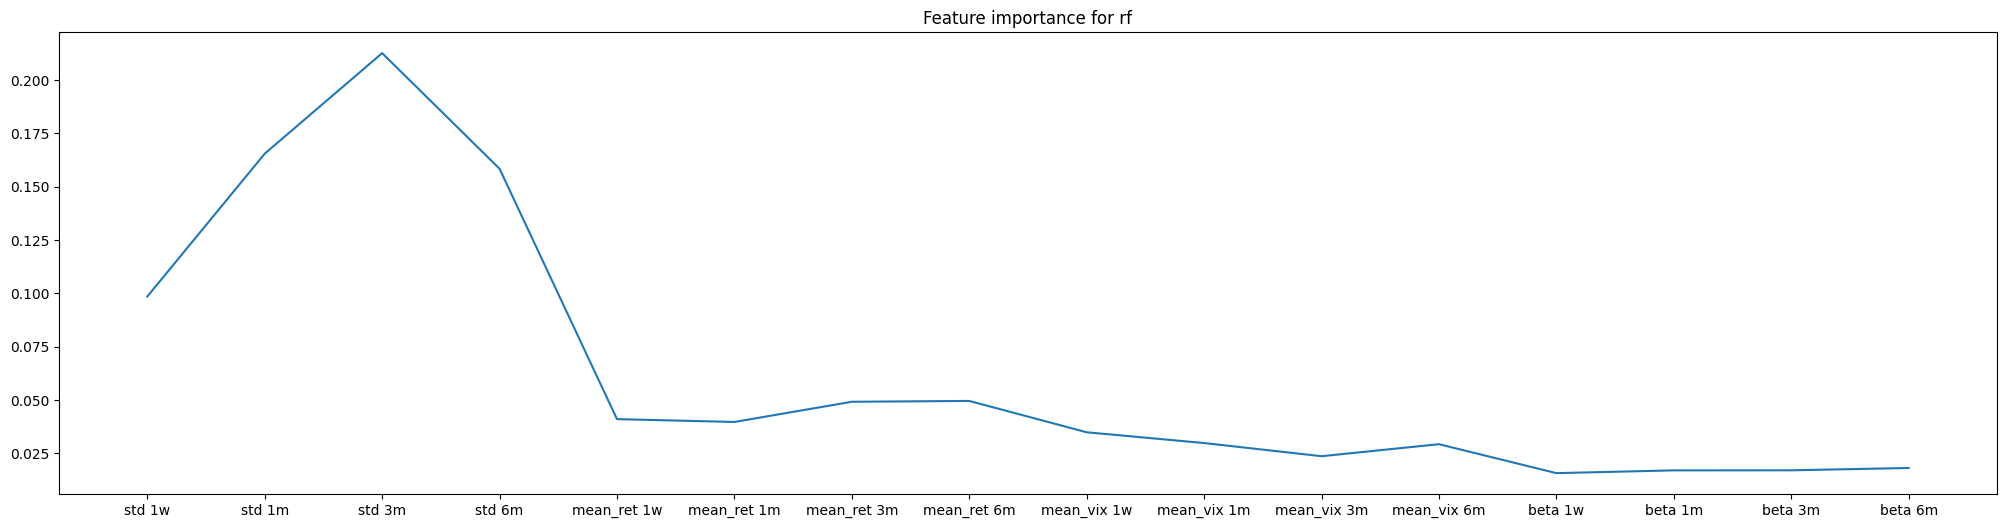

In [14]:
importances = methods["RandFor(features,std)-21"]["model"].feature_importances_
print(importances)
features = features.reshape(-1)

plt.figure(figsize=(25, 6))
plt.plot(importances)
plt.title("Feature importance for rf")
plt.xticks(range(len(x_label)), x_label)
plt.show()

Feed forward 

In [15]:
def get_feed_forward_model(A, B):
    model = Sequential()
    model.add(Dense(15, input_shape=(16,), activation='relu'))  # Prvi skriveni sloj
    model.add(Dense(15, activation='relu'))  # Drugi skriveni sloj
    model.add(Dense(1))  # Izlazni sloj

    # Kompilacija modela
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Obuka modela
    model.fit(A, B, epochs=50, batch_size=16, validation_split=0.2)

    return model

In [16]:
method = "FeedForward(features,std)" + "-" + str(forecast_horizon)
#reset_portfolio_metrics(method)

A, B = [], []

# Iterate over each window of returns
for stock in training_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        std = []
        mean_ret = []
        mean_vix = []
        betas = []
        
        for window in windows:
            #dobij sve feature koje ubacujemo u model
            std.append(returns_df[stock][i - window:i].std() * (252 ** 0.5) * 100)
            mean_ret.append(returns_df[stock][i - window:i].mean() * 252)
            mean_vix.append(float(vix_data[i - window: i].mean().iloc[0]))

            standardized_returns = standardize_returns(returns_df[stock][i - window:i])
            standardized_market_index_returns = standardize_returns(market_index_returns[i - window:i])
        

            X = standardized_returns
            y = standardized_market_index_returns
            
            model = get_linear_regression_model(X, y, fit_intercept=False)
            beta = model.coef_[0][0]
            if abs(beta) >= 1:
                raise Exception(f"Beta value {beta} is not in the range [-1, 1]")
            betas.append(beta)

        # Grupiraj kvadrirane povrate i prosječni VIX u jednu listu prije dodavanja u A
        features = std + mean_ret + mean_vix + betas
        
        
        # Sada dodaj tu listu kao jedan element u A
        A.append(features)
        B.append(returns_df[stock][i:i + forecast_horizon].std())

#A = scaler.fit_transform(A)
A = np.array(A)
B = np.array(B)

#A = A.reshape((A.shape[0], 16, 1))  # Oblikujemo X za LSTM: [samples, time steps, features]

methods[method]["model"] = get_feed_forward_model(A, B)



Epoch 1/50


c:\Users\filip\miniconda3\envs\everything\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 35.2007 - val_loss: 0.7321
Epoch 2/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5388 - val_loss: 0.3293
Epoch 3/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2620 - val_loss: 0.1762
Epoch 4/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1398 - val_loss: 0.1191
Epoch 5/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0995 - val_loss: 0.0794
Epoch 6/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0939 - val_loss: 0.0504
Epoch 7/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0454 - val_loss: 0.0328
Epoch 8/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0293 - val_loss: 0.0206
Epoch 9/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0419 - val_loss: 0.0186
Epoch 10/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0207 - val_loss: 0.0139
Epoch 11/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0065 - val_loss: 0.0223
Epoch 12/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0

In [17]:
volatility = {}

for i in range(test_start, test_end, forecast_horizon):

    temp = []
    betas_for_corr = []


    for stock in all_stocks:

        std = []
        mean_ret = []
        mean_vix = []
        betas = []

        for window in windows:
            #dobij sve feature koje ubacujemo u model
            std.append(returns_df[stock][i - window:i].std() * (252 ** 0.5) * 100)
            mean_ret.append(returns_df[stock][i - window:i].mean() * 252)
            mean_vix.append(float(vix_data[i - window: i].mean().iloc[0]))

            standardized_returns = standardize_returns(returns_df[stock][i - window:i])
            standardized_market_index_returns = standardize_returns(market_index_returns[i - window:i])
        

            X = standardized_returns
            y = standardized_market_index_returns
            
            model = get_linear_regression_model(X, y, fit_intercept=False)
            beta = model.coef_[0][0]
            if abs(beta) >= 1:
                raise Exception(f"Beta value {beta} is not in the range [-1, 1]")
            betas.append(beta)

            if window == 126:
                betas_for_corr.append(beta)

        # Grupiraj kvadrirane povrate i prosječni VIX u jednu listu prije dodavanja u A
        features = std + mean_ret + mean_vix + betas
        
        features = np.array(features).reshape(1, -1)
        #  Trying to predict the volatility of the next forecast_horizon days
        volatility[stock] = methods[method]["model"].predict(features).item()

        temp.append(volatility[stock])
    

    R = predict_corr(betas_for_corr)
    V = np.diag(temp)
    S = np.dot(np.dot(V, R), V)

    ef_cmv = EfficientFrontier(None, S, weight_bounds=(0, 1))
    ef_gmv = EfficientFrontier(None, S, weight_bounds=(-1, 1))
    ef_cmv.min_volatility()
    ef_gmv.min_volatility()

    weights_cmv = ef_cmv.clean_weights()
    weights_gmv = ef_gmv.clean_weights()
    
    gather_portfolio_metrics(method + "cmv", i, weights_cmv, volatility)
    gather_portfolio_metrics(method + "gmv", i, weights_gmv, volatility)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

LSTM


In [18]:
def get_lstm_model(A, B):
    model = Sequential()
    model.add(LSTM(50, input_shape=(5, A.shape[2]), return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
    model.add(LSTM(20, dropout=0.1))
    model.add(Dense(1, kernel_regularizer=l2(0.01)))  # Dodavanje L2 regularizacije
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Dodavanje ranog zaustavljanja kako bi se izbjeglo prenaučavanje
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    model.fit(A, B, epochs=100, batch_size=20, verbose=2, validation_split=0.2, callbacks=[early_stop])

    return model



In [19]:
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        seq = data[i:i + sequence_length]
        sequences.append(seq)
    return np.array(sequences)

In [20]:
"""method = "LSTM(features,std)" + "-" + str(forecast_horizon)
reset_portfolio_metrics(method)

scaler = MinMaxScaler()


A, B = [], []

# Iterate over each window of returns
for stock in training_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        std = []
        mean_ret = []
        mean_vix = []
        betas = []
        
        for window in windows:
            #dobij sve feature koje ubacujemo u model
            std.append(returns_df[stock][i - window:i].std() * (252 ** 0.5) * 100)
            mean_ret.append(returns_df[stock][i - window:i].mean() * 252)
            mean_vix.append(float(vix_data[i - window: i].mean().iloc[0]))

            standardized_returns = standardize_returns(returns_df[stock][i - window:i])
            standardized_market_index_returns = standardize_returns(market_index_returns[i - window:i])
        

            X = standardized_returns
            y = standardized_market_index_returns
            
            model = get_linear_regression_model(X, y, fit_intercept=False)
            beta = model.coef_[0][0]
            if abs(beta) >= 1:
                raise Exception(f"Beta value {beta} is not in the range [-1, 1]")
            betas.append(beta)

        # Grupiraj kvadrirane povrate i prosječni VIX u jednu listu prije dodavanja u A
        features = std + mean_ret + mean_vix + betas
        
        
        # Sada dodaj tu listu kao jedan element u A
        A.append(features)
        B.append(returns_df[stock][i:i + forecast_horizon].std())

#A = scaler.fit_transform(A)
A = np.array(A)
B = np.array(B)

#A = A.reshape((A.shape[0], 16, 1))  # Oblikujemo X za LSTM: [samples, time steps, features]
x_train = create_sequences(A, 5)

methods[method]["model"] = get_lstm_model(x_train, B)
"""


'method = "LSTM(features,std)" + "-" + str(forecast_horizon)\nreset_portfolio_metrics(method)\n\nscaler = MinMaxScaler()\n\n\nA, B = [], []\n\n# Iterate over each window of returns\nfor stock in training_stocks:\n    for i in range(train_start, train_end, forecast_horizon):\n        std = []\n        mean_ret = []\n        mean_vix = []\n        betas = []\n        \n        for window in windows:\n            #dobij sve feature koje ubacujemo u model\n            std.append(returns_df[stock][i - window:i].std() * (252 ** 0.5) * 100)\n            mean_ret.append(returns_df[stock][i - window:i].mean() * 252)\n            mean_vix.append(float(vix_data[i - window: i].mean().iloc[0]))\n\n            standardized_returns = standardize_returns(returns_df[stock][i - window:i])\n            standardized_market_index_returns = standardize_returns(market_index_returns[i - window:i])\n        \n\n            X = standardized_returns\n            y = standardized_market_index_returns\n           

In [21]:
"""volatility = {}

for i in range(test_start, test_end, forecast_horizon):
    for stock in all_stocks:

        std = []
        mean_ret = []
        mean_vix = []
        betas = []

        for window in windows:
            #dobij sve feature koje ubacujemo u model
            std.append(returns_df[stock][i - window:i].std() * (252 ** 0.5) * 100)
            mean_ret.append(returns_df[stock][i - window:i].mean() * 252)
            mean_vix.append(float(vix_data[i - window: i].mean().iloc[0]))

            standardized_returns = standardize_returns(returns_df[stock][i - window:i])
            standardized_market_index_returns = standardize_returns(market_index_returns[i - window:i])
        

            X = standardized_returns
            y = standardized_market_index_returns
            
            model = get_linear_regression_model(X, y, fit_intercept=False)
            beta = model.coef_[0][0]
            if abs(beta) >= 1:
                raise Exception(f"Beta value {beta} is not in the range [-1, 1]")
            betas.append(beta)

        # Grupiraj kvadrirane povrate i prosječni VIX u jednu listu prije dodavanja u A
        features = std + mean_ret + mean_vix + betas
        
        features = np.array(features).reshape(1, -1)
        #  Trying to predict the volatility of the next forecast_horizon days
        volatility[stock] = methods[method]["model"].predict(features).item()
    
    gather_portfolio_metrics(method, i, volatility)
    """

'volatility = {}\n\nfor i in range(test_start, test_end, forecast_horizon):\n    for stock in all_stocks:\n\n        std = []\n        mean_ret = []\n        mean_vix = []\n        betas = []\n\n        for window in windows:\n            #dobij sve feature koje ubacujemo u model\n            std.append(returns_df[stock][i - window:i].std() * (252 ** 0.5) * 100)\n            mean_ret.append(returns_df[stock][i - window:i].mean() * 252)\n            mean_vix.append(float(vix_data[i - window: i].mean().iloc[0]))\n\n            standardized_returns = standardize_returns(returns_df[stock][i - window:i])\n            standardized_market_index_returns = standardize_returns(market_index_returns[i - window:i])\n        \n\n            X = standardized_returns\n            y = standardized_market_index_returns\n            \n            model = get_linear_regression_model(X, y, fit_intercept=False)\n            beta = model.coef_[0][0]\n            if abs(beta) >= 1:\n                raise Exce

Xgboost


In [22]:
import xgboost as xgb
from sklearn.model_selection import train_test_split



def get_xbg_model(A, B):

    df = pd.DataFrame(A, columns=x_label)

    params = {
        'learning_rate': 0.1,
        'max_depth': 2,
        'n_estimators': 200,
        'subsample': 0.8,
        'colsample_bytree': 0.7,
    }

    # Inicijalizacija modela s definiranim parametrima
    model = xgb.XGBRegressor(**params)

    X_train, X_valid, y_train, y_valid = train_test_split(df, np.array(B), test_size=0.2, random_state=42)

    eval_set = [(X_train, y_train), (X_valid, y_valid)]
    model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, early_stopping_rounds=10, verbose=True)

    return model

In [23]:
method = "Xgboost(features,std)" + "-" + str(forecast_horizon)
#reset_portfolio_metrics(method)

A, B = [], []
# Iterate over each window of returns
for stock in training_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        std = []
        mean_ret = []
        mean_vix = []
        betas = []

        for window in windows:

            #dobij sve feature koje ubacujemo u model
            std.append(returns_df[stock][i - window:i].std()* (252 ** 0.5) * 100)
            mean_ret.append(returns_df[stock][i - window:i].mean() * 252)
            mean_vix.append(float(vix_data[i - window: i].mean().iloc[0]))

            standardized_returns = standardize_returns(returns_df[stock][i - window:i])
            #print(methods["EqualWeight"]["returns"][i - window:i])

            standardized_market_index_returns = standardize_returns(market_index_returns[i - window:i])
        
            X = standardized_returns
            y = standardized_market_index_returns
           
            model = get_linear_regression_model(X, y, fit_intercept=False)
            beta = model.coef_[0][0]
            if abs(beta) >= 1:
                raise Exception(f"Beta value {beta} is not in the range [-1, 1]")
            betas.append(beta)

        # Grupiraj kvadrirane povrate i prosječni VIX u jednu listu prije dodavanja u A
        features = std + mean_ret + mean_vix + betas
        
        # Sada dodaj tu listu kao jedan element u A
        A.append(features)
        B.append(returns_df[stock][i:i + forecast_horizon].std())


methods[method]["model"] = get_xbg_model(A, B) 
# Intercept might make variance negative



volatility = {}

for i in range(test_start, test_end, forecast_horizon):

    betas_for_corr = []
    temp = []
    
    for stock in all_stocks:

        std = []
        mean_ret = []
        mean_vix = []
        betas = []

        for window in windows:
            #dobij sve feature koje ubacujemo u model
            std.append(returns_df[stock][i - window:i].std() * (252 ** 0.5) * 100)
            mean_ret.append(returns_df[stock][i - window:i].mean() * 252)
            mean_vix.append(float(vix_data[i - window: i].mean().iloc[0]))

            standardized_returns = standardize_returns(returns_df[stock][i - window:i])
            standardized_market_index_returns = standardize_returns(market_index_returns[i - window:i])
        

            X = standardized_returns
            y = standardized_market_index_returns
            
            model = get_linear_regression_model(X, y, fit_intercept=False)
            beta = model.coef_[0][0]
            if abs(beta) >= 1:
                raise Exception(f"Beta value {beta} is not in the range [-1, 1]")
            betas.append(beta)

            if window == 126:
                betas_for_corr.append(beta)

        # Grupiraj kvadrirane povrate i prosječni VIX u jednu listu prije dodavanja u A
        features = std + mean_ret + mean_vix + betas
        
        features = np.array(features).reshape(1, -1)
        #  Trying to predict the volatility of the next forecast_horizon days
        volatility[stock] = methods[method]["model"].predict(features)
        temp.append(volatility[stock].tolist()[0])
    

    R = predict_corr(betas_for_corr)
    V = np.diag(temp)
    S = np.dot(np.dot(V, R), V)

    ef_cmv = EfficientFrontier(None, S, weight_bounds=(0, 1))
    ef_gmv = EfficientFrontier(None, S, weight_bounds=(-1, 1))
    ef_cmv.min_volatility()
    ef_gmv.min_volatility()

    weights_cmv = ef_cmv.clean_weights()
    weights_gmv = ef_gmv.clean_weights()
    
    gather_portfolio_metrics(method + "cmv", i, weights_cmv, volatility)
    gather_portfolio_metrics(method + "gmv", i, weights_gmv, volatility)


[0]	validation_0-rmse:0.01271	validation_1-rmse:0.01294
[1]	validation_0-rmse:0.01208	validation_1-rmse:0.01231
[2]	validation_0-rmse:0.01154	validation_1-rmse:0.01180
[3]	validation_0-rmse:0.01109	validation_1-rmse:0.01135
[4]	validation_0-rmse:0.01066	validation_1-rmse:0.01094
[5]	validation_0-rmse:0.01031	validation_1-rmse:0.01061
[6]	validation_0-rmse:0.00999	validation_1-rmse:0.01030
[7]	validation_0-rmse:0.00972	validation_1-rmse:0.01004
[8]	validation_0-rmse:0.00948	validation_1-rmse:0.00982
[9]	validation_0-rmse:0.00927	validation_1-rmse:0.00958
[10]	validation_0-rmse:0.00908	validation_1-rmse:0.00940
[11]	validation_0-rmse:0.00892	validation_1-rmse:0.00923
[12]	validation_0-rmse:0.00876	validation_1-rmse:0.00909
[13]	validation_0-rmse:0.00864	validation_1-rmse:0.00897
[14]	validation_0-rmse:0.00850	validation_1-rmse:0.00886
[15]	validation_0-rmse:0.00839	validation_1-rmse:0.00875
[16]	validation_0-rmse:0.00829	validation_1-rmse:0.00866
[17]	validation_0-rmse:0.00821	validation

c:\Users\filip\miniconda3\envs\everything\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\filip\miniconda3\envs\everything\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[67]	validation_0-rmse:0.00694	validation_1-rmse:0.00733
[68]	validation_0-rmse:0.00692	validation_1-rmse:0.00732
[69]	validation_0-rmse:0.00691	validation_1-rmse:0.00731
[70]	validation_0-rmse:0.00690	validation_1-rmse:0.00731
[71]	validation_0-rmse:0.00689	validation_1-rmse:0.00729
[72]	validation_0-rmse:0.00687	validation_1-rmse:0.00729
[73]	validation_0-rmse:0.00687	validation_1-rmse:0.00729
[74]	validation_0-rmse:0.00686	validation_1-rmse:0.00729
[75]	validation_0-rmse:0.00686	validation_1-rmse:0.00728
[76]	validation_0-rmse:0.00684	validation_1-rmse:0.00727
[77]	validation_0-rmse:0.00684	validation_1-rmse:0.00727
[78]	validation_0-rmse:0.00683	validation_1-rmse:0.00726
[79]	validation_0-rmse:0.00682	validation_1-rmse:0.00725
[80]	validation_0-rmse:0.00681	validation_1-rmse:0.00723
[81]	validation_0-rmse:0.00680	validation_1-rmse:0.00722
[82]	validation_0-rmse:0.00680	validation_1-rmse:0.00722
[83]	validation_0-rmse:0.00679	validation_1-rmse:0.00722
[84]	validation_0-rmse:0.00679	

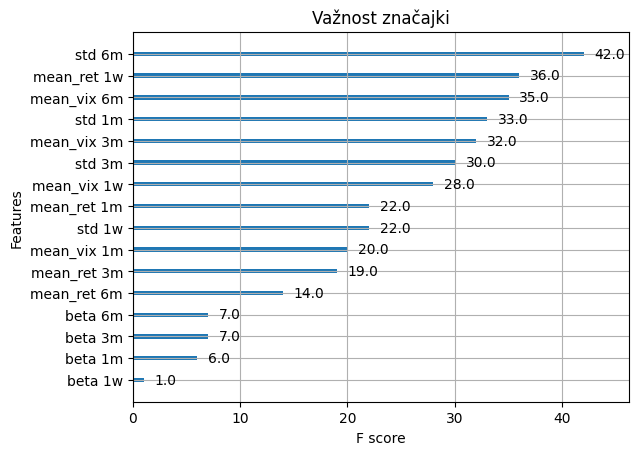

In [24]:
xgb.plot_importance(methods["Xgboost(features,std)-21"]["model"])
plt.title('Važnost značajki')
plt.show()

In [25]:
keys_to_remove = ['RandFor(features,std)-21', 'LinReg(features,std)-21', "FeedForward(features,std)-21", "Xgboost(features,std)-21"]

for key in keys_to_remove:
    methods.pop(key)


Portfolio performance

In [26]:
#potroflio metrics
portfolios_df = {
    "Portfolio": [method for method in methods],
    "Volatility": [np.std(portfolio["returns"]) * 252**0.5 \
                   for portfolio in methods.values()],
    "Return": [(1 + np.average(portfolio["returns"]))**252 - 1 \
               for portfolio in methods.values()],
    "Sharpe": [((1 + np.average(portfolio["returns"]))**252 - 1) \
               / (np.std(portfolio["returns"]) * 252**0.5) \
                for portfolio in methods.values()]
}


display(pd.DataFrame(portfolios_df))

Portfolio  Volatility    Return    Sharpe
0       LinReg(features,std)-21cmv    0.107841  0.139085  1.289724
1       LinReg(features,std)-21gmv    0.126542  0.165913  1.311132
2      RandFor(features,std)-21cmv    0.106424  0.141441  1.329028
3      RandFor(features,std)-21gmv    0.128126  0.156473  1.221246
4  FeedForward(features,std)-21cmv    0.121254  0.111082  0.916108
5  FeedForward(features,std)-21gmv    0.124685  0.140005  1.122877
6      Xgboost(features,std)-21cmv    0.107905  0.142584  1.321388
7      Xgboost(features,std)-21gmv    0.129798  0.157286  1.211780

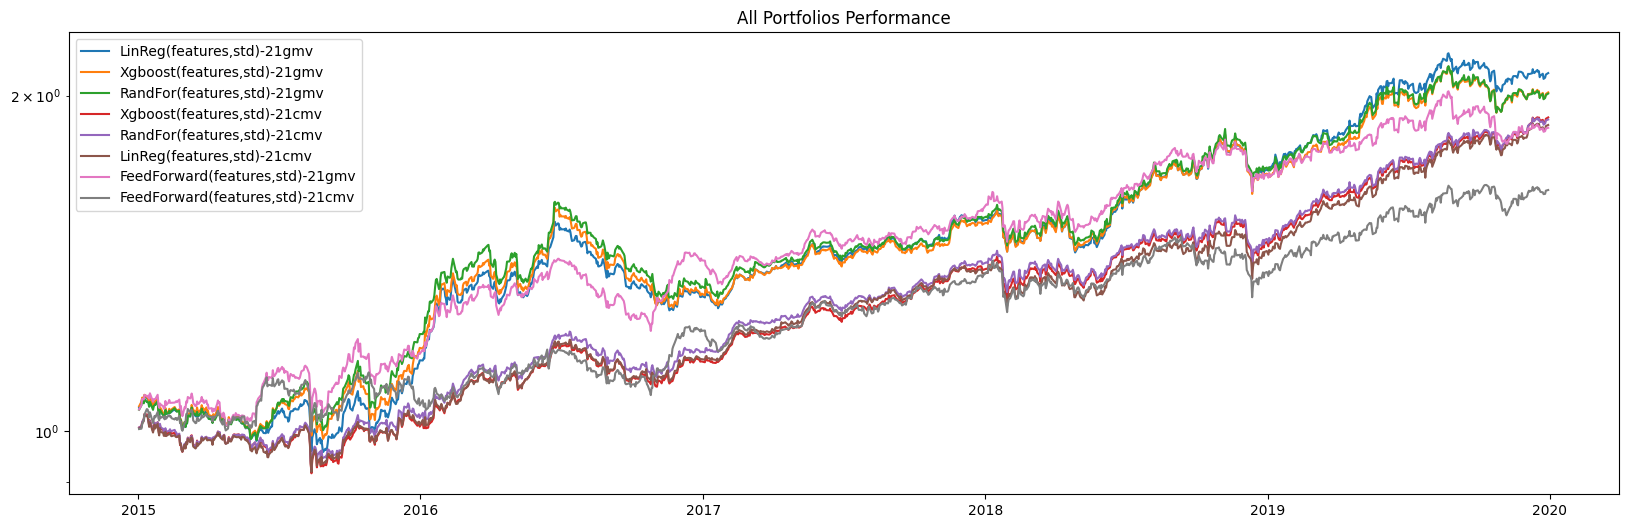

In [27]:
# Iterate over each portfolio in methods
for portfolio in methods.values():
    # Initialize the value list with a starting value of 1
    portfolio["value"] = [1]

    # Calculate the cumulative value of the portfolio
    for ret in portfolio["returns"]:
        portfolio["value"].append((ret + 1) * portfolio["value"][-1])

# Get the dates for the test period
dates = returns_df.iloc[test_start:test_end, 0]

# Sort the methods by the final value of the portfolio, in descending order
sorted_methods = sorted(\
    methods.items(), key=lambda method: method[1]["value"][-1], reverse=True)

i = 1
# Plot the performance of all portfolios
plt.figure(figsize=(20, 6))
for method, portfolio in sorted_methods:
    plt.semilogy(dates, portfolio["value"][8:], label=method)
plt.title("All Portfolios Performance")
plt.legend()
plt.show()

In [28]:
def calculate_mse(actual, predicted, stocks=all_stocks):
    mse = []
    for stock in stocks:
        mse.append(mean_squared_error(\
            actual[stock + " predicted volatility"], \
                predicted[stock + " predicted volatility"]))
    return np.mean(mse)

MSE

In [29]:
methods_df = {
    "Method": [method for method in methods],
    "MSE All Stocks": [calculate_mse(\
        methods["Oracle+" + str(forecast_horizon)], methods[method]) \
            if method != "EqualWeight" else None for method in methods],
    "MSE Trained Stocks": [calculate_mse(\
        methods["Oracle+" + str(forecast_horizon)], methods[method], training_stocks) \
            if all(not method.startswith(prefix) \
                for prefix in ["EqualWeight"]) \
                    else None for method in methods],
    "MSE Other Stocks": [calculate_mse(\
        methods["Oracle+" + str(forecast_horizon)], methods[method], other_stocks) \
            if all(not method.startswith(prefix) \
                for prefix in ["EqualWeight"]) \
                    else None for method in methods]
}

display(pd.DataFrame(methods_df).loc[lambda df: df['Method'] != 'EqualWeight'])

ValueError: Found input variables with inconsistent numbers of samples: [0, 61]

In [30]:
methods

defaultdict(<function __main__.<lambda>()>,
            {'LinReg(features,std)-21cmv': defaultdict(list,
                         {'MSFT predicted volatility': [array([0.0124838]),
                           array([0.02082829]),
                           array([0.0136629]),
                           array([0.01616904]),
                           array([0.01516055]),
                           array([0.01517457]),
                           array([0.01516213]),
                           array([0.01178882]),
                           array([0.02270226]),
                           array([0.01744917]),
                           array([0.01887275]),
                           array([0.01473608]),
                           array([0.01584053]),
                           array([0.02073785]),
                           array([0.01874094]),
                           array([0.01511036]),
                           array([0.01520794]),
                           array([0.0135611]),
     